# Face detection and BMI/Age/Sex prediction

The model provides end-to-end capability of detecting faces and predicting the BMI, Age and Gender for each person. 

The architecture of the model is described as below:

![](./img/model_structure.jpg)


## Face detection

Face detection is done by `MTCNN`, which is able to detect multiple faces within an image and draw the bounding box for each faces.  

It serves two purposes for this project:

### 1) preprocess and align the facial features of image.

Prior model training, each image is preprocessed by `MTCNN` to extract faces and crop images to focus on the facial part. The cropped images are saved and used to train the model in later part.

Illustration of face alignment:
![](./img/mtcnn_face_alignment.jpg)

### 2) enable prediction for multiple persons in the same image.

In inference phase, faces will be detected from the input image. For each face, it will go through the same preprocssing and make the predictions.

Illustration of ability to predict for multiple faces:
![](./img/detect_predict_multi_faces.png)

## Multi-task prediction

In vanilla CNN architecture, convolution blocks are followed by the dense layers to make output the prediction. In a naive implementation, we can build 3 models to predict BMI, age and gender individually. However, there is a strong drawback that 3 models are required to be trained and serialized separately, which drastically increases the maintenance efforts.

|   |
|---|
|`[input image] => [VGG16] => [dense layers] => [BMI]`|
|`[input image] => [VGG16] => [dense layers] => [AGE]`|
|`[input image] => [VGG16] => [dense layers] => [SEX]`|

Since we are going to predict `BMI`, `Age`, `Sex` from the same image, we can share the same backbone for the three different prediction heads and hence only one model will be maintained.

|    |
|----|
|`[input image] => [VGG16] => [separate dense layers] x3 => weighted([BMI], [AGE], [SEX])`|

This is the most simplified multi-task learning structure, which assumed independent tasks and hence separate dense layers were used for each head. Other research such as `Deep Relationship Networks`, used `matrix priors` to model the relationship between tasks.

![](https://ruder.io/content/images/2017/05/relationship_networks.png)
_A Deep Relationship Network with shared convolutional and task-specific fully connected layers with matrix priors (Long and Wang, 2015)._
 
## Reference
 * MTCNN: [https://github.com/ipazc/mtcnn](https://github.com/ipazc/mtcnn)
 * VGGFace: [https://github.com/rcmalli/keras-vggface](https://github.com/rcmalli/keras-vggface)

In [1]:
mode = 'train' #'train' or 'predict'
model_type = 'vgg16'
model_tag = 'base'
model_id = '{:s}_{:s}'.format(model_type, model_tag)
model_dir = './saved_model/model_{:s}.h5'.format(model_id)
bs = 8
epochs = 2
freeze_backbone = True # True => transfer learning; False => train from scratch

In [2]:
import pandas as pd
import os
import json
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
from scripts.models import FacePrediction
import glob

allimages = os.listdir('./data/face_aligned/')
train = pd.read_csv('./data/train.csv')
valid = pd.read_csv('./data/valid.csv')

train = train.loc[train['index'].isin(allimages)]
valid = valid.loc[valid['index'].isin(allimages)]

Using TensorFlow backend.


In [3]:
# create metrics, model dirs
Path('./metrics').mkdir(parents = True, exist_ok = True)
Path('./saved_model').mkdir(parents = True, exist_ok = True)

## Data

This is fairly small dataset, which comprises 1530 records and  16 columns.

* sex imbalance: 80% of the data is male
* age is near truncated normal distribution. min Age is 18, average Age is 34.
* race is dominated by Black and White. Asian samples are very limited.
* BMI is normal distrbuted, with mean at 26.

* no obvious correlation found between BMI and Age, Sex.

In [4]:
data = pd.concat([train, valid])
data[['age','race','sex','bmi','index']].head()

,age,race,sex,bmi,index
0,21,Black,Male,23.028211,270020.jpg
1,29,White,Male,29.529925,277774.jpg
2,18,White,Male,19.005974,279426.jpg
3,23,Asian,Male,28.889081,279799.jpg
4,19,Black,Male,21.109221,281182.jpg


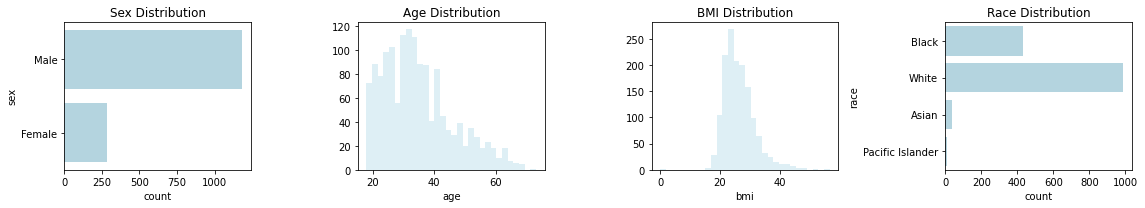

In [5]:
color = 'lightblue'
fig, axs = plt.subplots(1,4)
fig.set_size_inches((16, 3))
sns.countplot(y = data.sex, color = color, ax = axs[0])
axs[0].set_title('Sex Distribution')
sns.distplot(data.age,  bins = 30, kde=False, color=color, ax = axs[1])
axs[1].set_title('Age Distribution')
sns.distplot(data.bmi,  bins = 30, kde=False, color=color, ax = axs[2])
axs[2].set_title('BMI Distribution')
sns.countplot(y = data.race, color = color, ax = axs[3])
axs[3].set_title('Race Distribution')
plt.tight_layout()

In [6]:
def sns_hist(data, x, hue, ax = None, title = 'title', xlabel = None, **kwargs):
    
    xlabel = x.upper() if xlabel == None else xlabel
    
    group = data[hue].unique()
    for g in group:
        sns.distplot(data.loc[data[hue] == g, x], label = g, ax = ax,  **kwargs)
    if ax == None:
        plt.legend()
        plt.title(title)
        plt.xlabel(xlabel)
    else:
        ax.legend()
        ax.set_title(title)
        ax.set_xlabel(xlabel)
    return ax

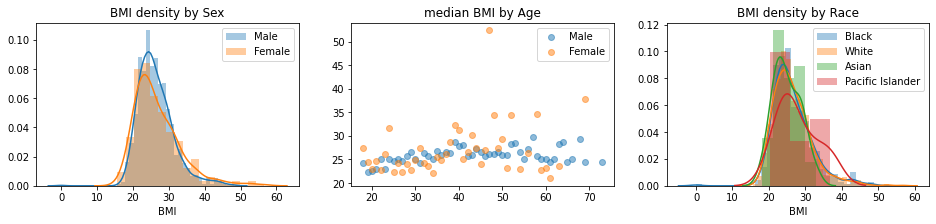

In [8]:
fig, axs = plt.subplots(1,3)
fig.set_size_inches((16, 3))

sns_hist(data, x = 'bmi', hue = 'sex', ax = axs[0], title = 'BMI density by Sex', kde = True)

res = data.groupby(['age','sex'], as_index=False)['bmi'].median()
for i in ['Male','Female']:
    axs[1].scatter(res.loc[res.sex == i,'age'].values, res.loc[res.sex == i,'bmi'].values,label = i, alpha = 0.5)
axs[1].set_title('median BMI by Age')
axs[1].legend()

sns_hist(data, x = 'bmi', hue = 'race', ax = axs[2], title = 'BMI density by Race', kde = True)

plt.show()

## Training

In [9]:
es = EarlyStopping(patience=3)
ckp = ModelCheckpoint(model_dir, save_best_only=True, save_weights_only=True, verbose=1)
tb = TensorBoard('./tb/%s'%(model_id))
callbacks = [es, ckp]

model = FacePrediction(img_dir = './data/face_aligned/', model_type = model_type)
model.define_model(freeze_backbone = freeze_backbone)
model.model.summary()
if mode == 'train':
    model_history = model.train(train, valid, bs = bs, epochs = epochs, callbacks = callbacks)
else:
    model.load_weights(model_dir)

W0726 10:10:37.945470 140576260450112 deprecation_wrapper.py:119] From /home/chaoran/anaconda3/envs/face2bmi/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0726 10:10:37.946276 140576260450112 deprecation_wrapper.py:119] From /home/chaoran/anaconda3/envs/face2bmi/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0726 10:10:37.947661 140576260450112 deprecation_wrapper.py:119] From /home/chaoran/anaconda3/envs/face2bmi/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0726 10:10:37.961238 140576260450112 deprecation_wrapper.py:119] From /home/chaoran/anaconda3/envs/face2bmi/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 224, 224, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 224, 224, 64) 36928       conv1_1[0][0]                    
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 112, 112, 64) 0           conv1_2[0][0]                    
__________________________________________________________________________________________________
conv2_1 (C

Epoch 1/2
149/149 [==============================] - 93s 626ms/step - loss: 20.1497 - bmi_loss: 21.3718 - age_loss: 30.3141 - sex_loss: 0.2085 - sex_acc: 0.9178 - val_loss: 13.0324 - val_bmi_loss: 13.2676 - val_age_loss: 24.0844 - val_sex_loss: 0.0992 - val_sex_acc: 0.9621

Epoch 00001: val_loss improved from inf to 13.03240, saving model to ./saved_model/model_vgg16_base.h5
Epoch 2/2
149/149 [==============================] - 92s 616ms/step - loss: 8.3497 - bmi_loss: 8.4284 - age_loss: 15.9885 - sex_loss: 0.0817 - sex_acc: 0.9765 - val_loss: 6.5085 - val_bmi_loss: 6.7135 - val_age_loss: 11.3252 - val_sex_loss: 0.0522 - val_sex_acc: 0.9924

Epoch 00002: val_loss improved from 13.03240 to 6.50855, saving model to ./saved_model/model_vgg16_base.h5


## Evaluations

![](./img/tensorboard_results.png)

| Model | BMI (RMSE) | Age (RMSE) | Sex (AUC) |
|-------|------------|------------|-----------|
|vgg16  |4.56|5.66|0.99|
|vgg16_fc6| 4.99 | 6.04 | 0.99 |
|resnet50|5.21 | 7.02 | 0.99|

In [10]:
valid['gender'] = valid.sex.map(lambda i: 1 if i == 'Male' else 0)

In [13]:
metrics = model.evaulate(valid)
metrics['model'] = model_type
with open('./metrics/{:s}.json'.format(model_type), 'w') as f:
    json.dump(metrics, f)

metrics = []
for i in glob.glob('./metrics/*.json'):
    with open(i, 'r') as f:
        res = json.load(f)
    metrics.append(res)
metrics = pd.DataFrame(metrics)
metrics['model'] = metrics['model'].apply(lambda i: '* ' + i if i == model_id else i)
metrics.set_index('model').round(3)

,bmi_mae,bmi_cor,age_mae,sex_auc
model,,,,
vgg16,6.536,0.31,11.029,0.999


## Predictions

### predict from a single image

In [14]:
model.predict('./data/test/test_aligned/trump.jpg')

[array([[21.022844]], dtype=float32),
 array([[54.279297]], dtype=float32),
 array([[0.9728872]], dtype=float32)]

### predict from a directory

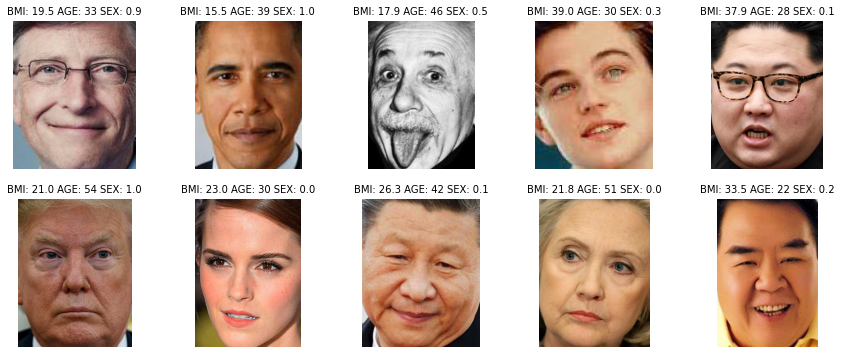

In [15]:
preds = model.predict('./data/test/test_aligned/', show_img = True)

In [16]:
model.predict_df('./data/test/test_aligned')

,img,bmi,age,sex,sex_prob
0,bill-gates.jpg,19.455412,32.782104,Male,0.858390
1,barack-obama.jpg,15.456940,38.531124,Male,0.970255
2,albert-einstein.jpg,17.859999,46.487255,Male,0.502909
3,leonardo.jpeg,38.984314,30.258320,Male,0.325414
4,Kim Jong-un.jpg,37.886211,27.564148,Male,0.072841
5,trump.jpg,21.022848,54.279301,Male,0.972887
6,emma_watson.jpg,23.002207,29.919064,Female,0.000523
7,xi.jpg,26.265472,42.072498,Male,0.098992
8,hilary_clinton.jpg,21.756514,51.147022,Female,0.000103
9,kent_zheng.jpg,33.507439,22.075207,Male,0.247732


### predict multiple faces

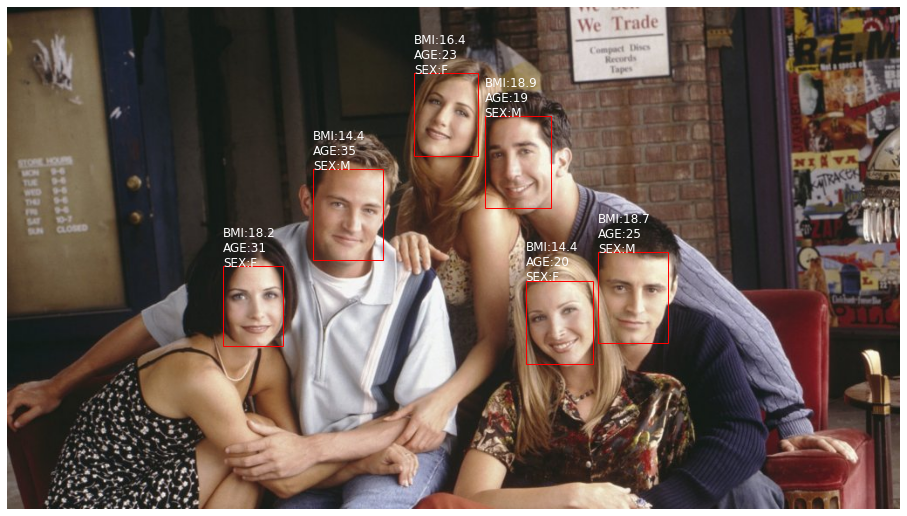

In [17]:
preds = model.predict_faces('./data/test/multi_face/friends.jpg', color = 'white')

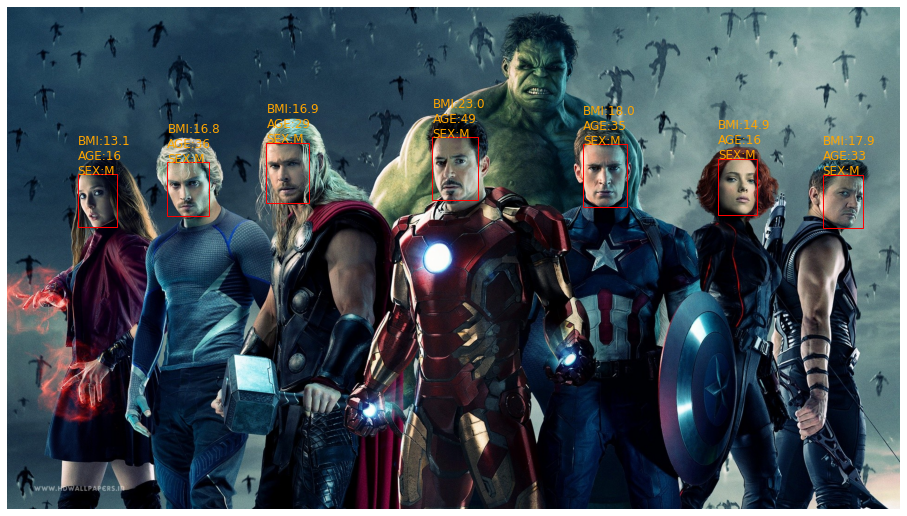

In [18]:
preds = model.predict_faces('./data/test/multi_face/avengers.jpg', color = 'orange')